# French presidents' popularity

In [8]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']})

/usr/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## Exploratory data analysis

In [3]:
data = pd.read_csv('./plot_data/raw_polls.csv', parse_dates = True, index_col="Unnamed: 0")
data['year'] = data.index.year
data['month'] = data.index.month
data['sondage'] = data['sondage'].replace('Yougov', 'YouGov')

minimum = np.min(data[["year"]].values)
maximum = np.min(data[["year"]].values)
pollsters = data["sondage"].unique()

comment = f"""The dataset contains {len(data)} polls between the years {minimum} and {maximum}.
There are {len(pollsters)} pollsters: {', '.join(list(pollsters))}
"""
print(comment)

The dataset contains 1052 polls between the years 2002 and 2002.
There are 10 pollsters: Ifop, Kantar, BVA, Ipsos, Odoxa, Elabe, Viavoice, YouGov, Harris, OpinionWay



Let us look at simple stats on the pollsters. First the total number of polls they've produced:

In [4]:
data["sondage"].value_counts()

Ifop          239
Ipsos         215
Kantar        208
BVA           187
Odoxa          65
Elabe          50
Harris         30
YouGov         29
Viavoice       17
OpinionWay     12
Name: sondage, dtype: int64

For most pollsters we should be able to estimate their bias quite accurately, however `YouGov` has only 3 points and its estimated bias will heavily depend on the prior we chose. Let us now count the number of polls per year:

In [5]:
data['year'].value_counts().sort_index()

2002     30
2003     47
2004     44
2005     47
2006     43
2007     40
2008     45
2009     45
2010     45
2011     44
2012     44
2013     45
2014     49
2015     55
2016     54
2017     80
2018    101
2019    105
2020     82
2021      7
Name: year, dtype: int64

There are substantially more polls in the years 2017, 2018 and 2019. The lower count for 2002 and 2021 is explained by the fact that we don't have the full year.

How many are there per month?

In [6]:
data['month'].value_counts().sort_index() / len(data['year'].unique())

1     4.75
2     4.45
3     4.45
4     4.30
5     4.55
6     4.75
7     3.40
8     3.50
9     4.70
10    4.80
11    4.90
12    4.05
Name: month, dtype: float64

The number of polls is homogeneous among months, except in the summer because, well, France. The average number of polls per month (roughly 4) seems large enough to hope get a good model.

When it comes to the method it seems that pollsters prefer the phone over the internet and face-to-face. There is still a substantial number of each should we have to estimate biais.

In [7]:
data['method'].value_counts()

phone                    447
internet                 365
face to face             206
phone&internet            33
face-to-face&internet      1
Name: method, dtype: int64

## Let's look at the data!

Let us now plot the approval rate of presidents over time. The vertical line correspond to a new presidential term.

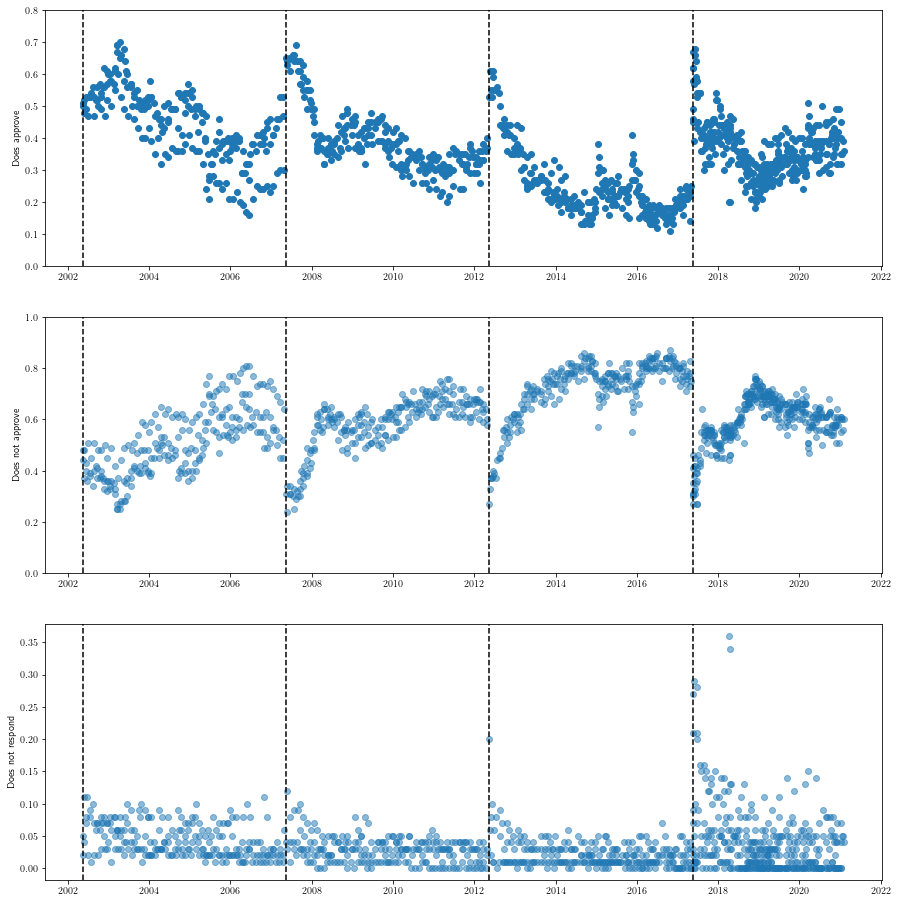

In [16]:
approval_rates = data["p_approve"].values
disapproval_rates = data["p_disapprove"].values
newterm_dates = data.reset_index().groupby("president").first()["index"].values
doesnotrespond = 1 - approval_rates - disapproval_rates

dates = data.index

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,16))
ax1.plot(dates, approval_rates, 'o')
ax1.set_ylim(0, .8)
ax1.set_ylabel("Does approve")
for date in newterm_dates:
    ax1.axvline(date, color='black', linestyle='--')

ax2.plot(dates, disapproval_rates, 'o', alpha=.5)
ax2.set_ylabel("Does not approve")
ax2.set_ylim(0, 1)
for date in newterm_dates:
    ax2.axvline(date, color='black', linestyle='--')
    
ax3.plot(dates, doesnotrespond, 'o', alpha=.5)
ax3.set_ylabel("Does not respond")
for date in newterm_dates:
    ax3.axvline(date, color='black', linestyle='--')

We notice two things looking at these plots:

1. Approval rates strikingly systematically decreased at the terms comes along;
2. While that's true, some events seems to push the approval rate back up, even though temporarily. This happened in every term, actually. Can that variance be explained solely with a random walk?
3. Non-response rate is quite high during Macron's term.

## Estimating the biais: naive method

### Method bias

We plot the approval rate conditionned on three methods: phone, internet and face-to-face.

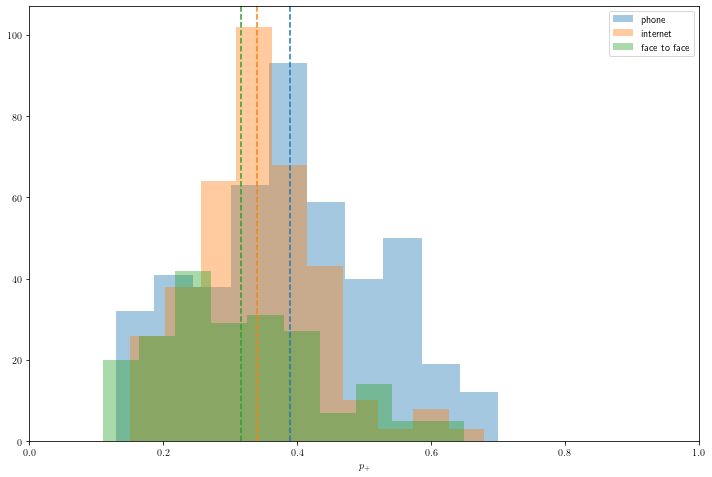

In [18]:
phone = data[data["method"] == "phone"]["p_approve"].values
internet = data[data["method"] == "internet"]["p_approve"].values
facetoface = data[data["method"] == "face to face"]["p_approve"].values

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(12,8))

c = next(colors)["color"]
ax.hist(phone, label="phone", color=c, alpha=.4)
ax.axvline(np.mean(phone), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(internet, label="internet", color=c, alpha=.4)
ax.axvline(np.mean(internet), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(facetoface, label="face to face", color=c, alpha=.4)
ax.axvline(np.mean(facetoface), color=c, linestyle='--')

ax.set_xlabel(r"$p_{+}$")
ax.set_xlim(0,1)
plt.legend()

### Pollster bias

We plot the distribution of the approval rates for each pollster. Note that this is not very scientific: pollsters like YouGov appeared recently so their rates will be tilted towards the last presidents' popularity while the other will be more evenly distributed.

Unsurprisingly, the bulk of the distributions is below .5 (remember French people don't like their presidents).

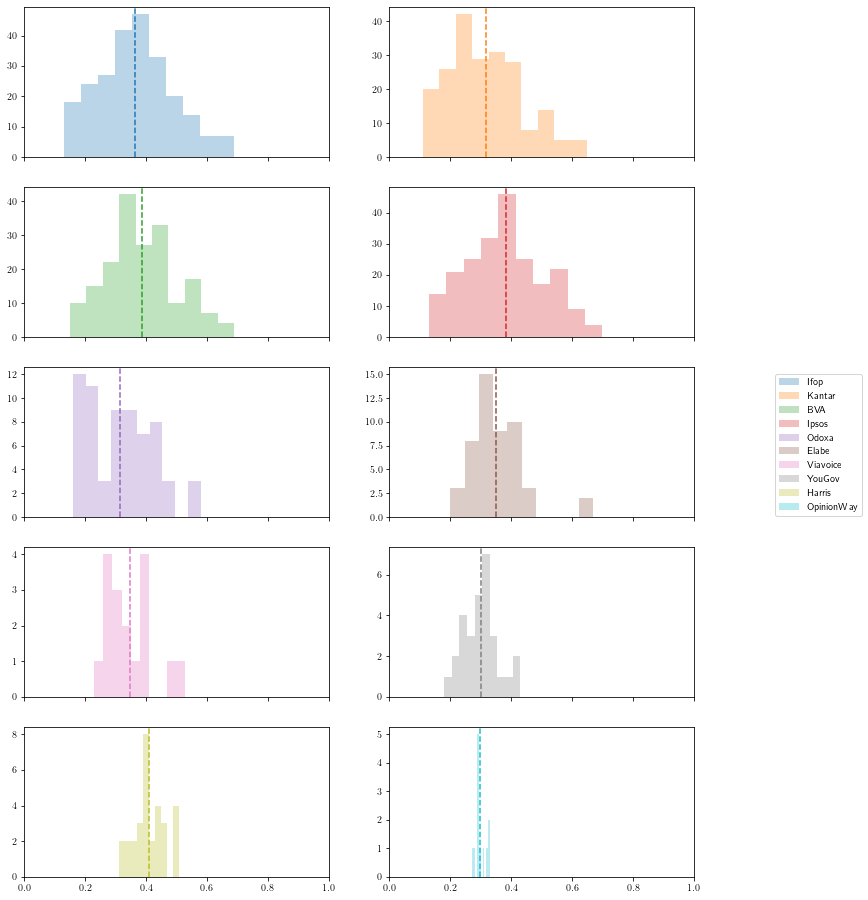

In [17]:
pollster_vals = {pollster: data[data["sondage"] == pollster]["p_approve"].values for pollster in list(pollsters)}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12,16))
axes = [ax for axs in axes for ax in axs]
for ax, (pollster, vals) in zip(axes, pollster_vals.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle='--')

ax.set_xlim(0,1)
fig.legend(loc="right", bbox_to_anchor=(1.1, .5))

## Rolling standard deviation

We now compute the rolling variance of the approval rates. We weigh each poll equally, even though we probably should weigh them according to their respective sample size.

In [19]:
rolling_std = data.reset_index().groupby(['year', 'month']).std().reset_index()[["year", "month", "p_approve"]]

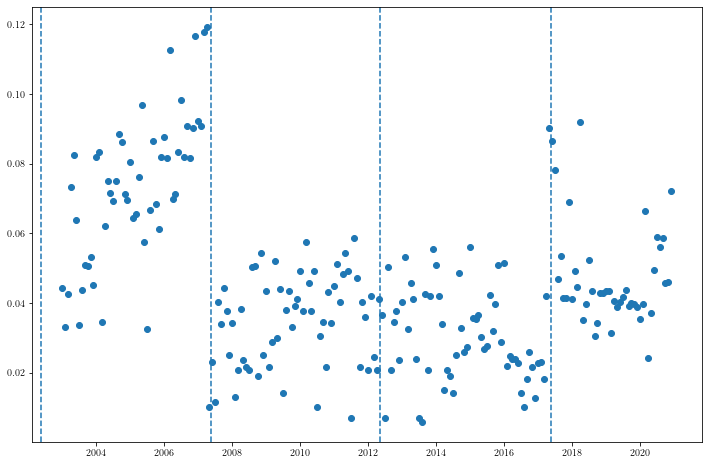

In [20]:
years = [f"{i}" for i in range(2003, 2021)]
values = rolling_std[rolling_std["year"].between(2003, 2020)]["p_approve"].values
dates = [datetime.datetime.strptime(f"{year}-{month}", '%Y-%m') for year in years for month in range(1, 13) ]

newterm_dates = data.reset_index().groupby("president").first()["index"].values

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dates, values, 'o')
for date in newterm_dates:
    ax.axvline(date, linestyle='--')
    

There is an abnormally high variance for Chirac's second term, and for the beggining of Macron's term. As a matter of fact, the previous scatterplot of $p_{approve}$ clearly shows almost two different curves. Let's look at the data for Chirac's term directly:

In [12]:
chirac = data[data["president"] == "chirac2"]
chirac2007 = chirac[chirac["year"] >= 2006]
chirac2007

,president,sondage,samplesize,method,p_approve,p_disapprove,year,month
2006-01-16,chirac2,Ifop,905,phone,0.37,0.61,2006,1
2006-01-17,chirac2,Ipsos,987,phone,0.38,0.57,2006,1
2006-01-19,chirac2,BVA,1043,phone,0.40,0.52,2006,1
2006-01-24,chirac2,Kantar,911,face to face,0.21,0.77,2006,1
2006-02-18,chirac2,BVA,953,phone,0.39,0.53,2006,2
2006-02-19,chirac2,Ipsos,971,phone,0.41,0.56,2006,2
2006-02-20,chirac2,Ifop,971,phone,0.37,0.61,2006,2
2006-02-26,chirac2,Kantar,933,face to face,0.23,0.75,2006,2
2006-03-17,chirac2,Ifop,982,phone,0.39,0.60,2006,3
2006-03-21,chirac2,Ipsos,1062,phone,0.40,0.57,2006,3


And now for the beggining of Macron's term

In [13]:
macron = data[data["president"] == "macron"]
macron2017 = macron[macron["year"] == 2017]
macron2017.head(20)

,president,sondage,samplesize,method,p_approve,p_disapprove,year,month
2017-05-17,macron,Elabe,999,internet,0.45,0.46,2017,5
2017-05-20,macron,Ifop,973,phone,0.62,0.31,2017,5
2017-05-20,macron,Ipsos,1015,internet,0.46,0.27,2017,5
2017-05-21,macron,Viavoice,1006,internet,0.49,0.30,2017,5
2017-05-23,macron,BVA,1011,internet,0.62,0.35,2017,5
2017-05-23,macron,Odoxa,1014,internet,0.58,0.41,2017,5
2017-05-24,macron,Elabe,1051,internet,0.67,0.31,2017,5
2017-05-25,macron,YouGov,1008,internet,0.39,0.32,2017,5
2017-05-27,macron,Ipsos,2138,internet,0.58,0.42,2017,5
2017-05-27,macron,Kantar,1008,face to face,0.57,0.38,2017,5


For Chirac's term it seems that difference stems from the polling method; face-to-face approval rates seem to be much lower. Let's visualize it:

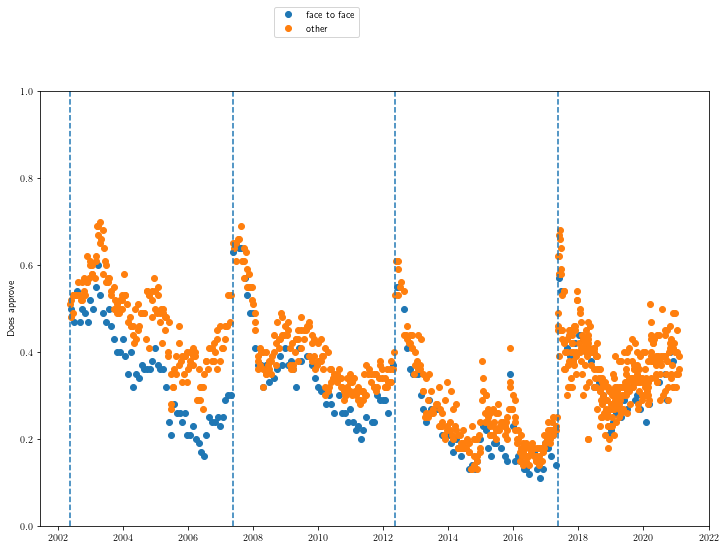

In [21]:
face = data[data['method'] == 'face to face']
dates_face = face.index

other = data[data['method'] != 'face to face']
dates_other = other.index

newterm_dates = data.reset_index().groupby("president").first()["index"].values


fig, ax = plt.subplots(figsize=(12,8))
ax.plot(dates_face, face['p_approve'].values, 'o', label='face to face')
ax.plot(dates_other, other['p_approve'].values, 'o', label='other')
for date in newterm_dates:
    ax.axvline(date, linestyle='--')

ax.set_ylim(0, 1)
ax.set_ylabel("Does approve")
fig.legend(loc='right', bbox_to_anchor=(.5, 1))

Similarly it appears to be strongly correlated with pollsters. But since only Kantar does face-to-face these correlations are one and the same:

In [15]:
data[data["sondage"] == "Kantar"]["method"].value_counts()

face to face             206
face-to-face&internet      1
internet                   1
Name: method, dtype: int64

In [16]:
data[data["method"] == "face to face"]["sondage"].value_counts()

Kantar    206
Name: sondage, dtype: int64

In [17]:
data[data["sondage"] == "Ifop"]["method"].value_counts()

phone             181
phone&internet     33
internet           25
Name: method, dtype: int64

**TODO:** This difference of results between methods may be explained by the difference in "does not respond" rate. In which case we may have to model this as well.

## A more serious analysis of bias

To investigate bias we now compute the rolling mean of the $p_{approve}$ values and compare each method's and pollster's deviations to the mean.

In [22]:
data = data.merge(data.groupby(['year', 'month'])['p_approve'].mean().reset_index(), on=['year', 'month'], suffixes=["", "_mean"])
data['diff_approval'] = data['p_approve_mean'] - data['p_approve']

Text(0.5, 0, '$\\bar{p}_{approve} - p_{approve}$')

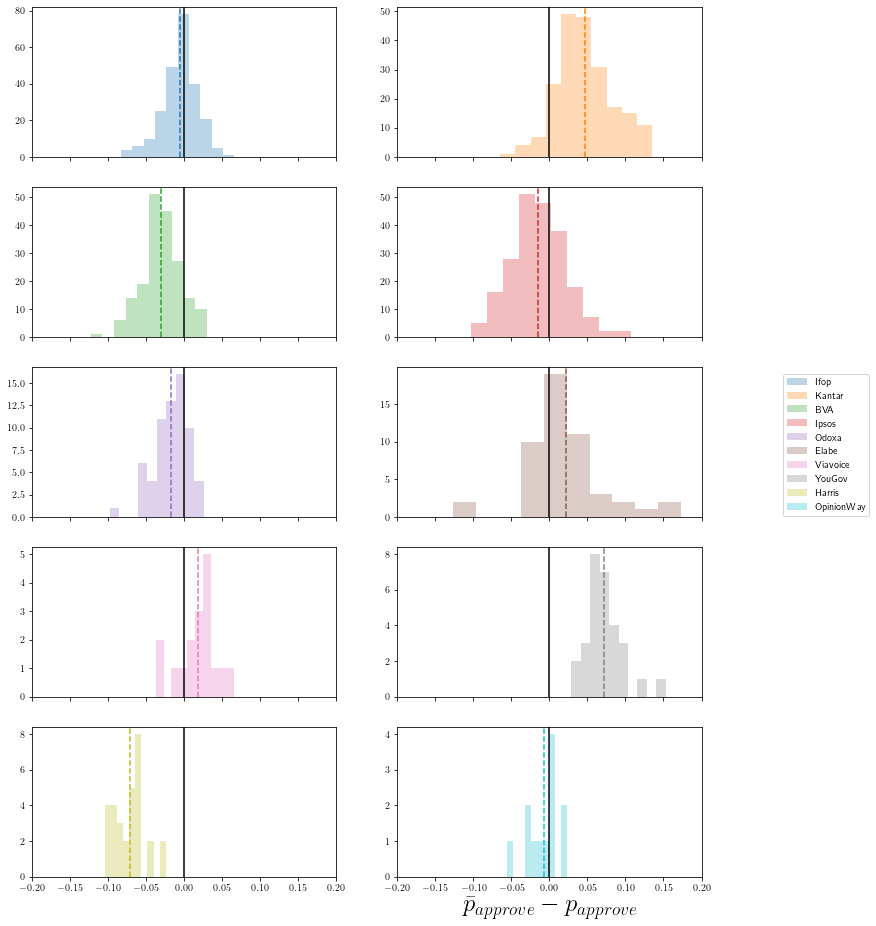

In [29]:
pollster_vals = {pollster: data[data["sondage"] == pollster]["diff_approval"].values for pollster in list(pollsters)}

colors = plt.rcParams["axes.prop_cycle"]()
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12,16))
axes = [ax for axs in axes for ax in axs]
for ax, (pollster, vals) in zip(axes, pollster_vals.items()):
    c = next(colors)["color"]
    ax.hist(vals, alpha=.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle='--')
    ax.axvline(x=0, color='black')

ax.set_xlim(-.2,.2)
fig.legend(loc="right", bbox_to_anchor=(1.1, .5))
plt.xlabel(r"$\bar{p}_{approve} - p_{approve}$", fontsize=25)


And we do the same to evaluate the bias per method:

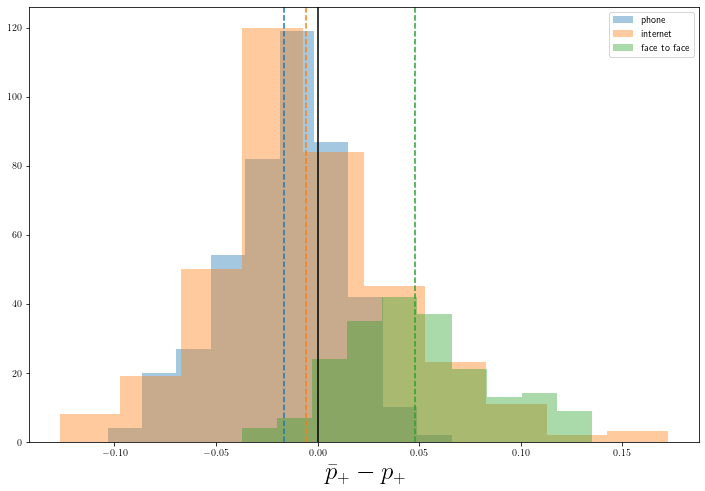

In [30]:
phone = data[data["method"] == "phone"]["diff_approval"].values
internet = data[data["method"] == "internet"]["diff_approval"].values
facetoface = data[data["method"] == "face to face"]["diff_approval"].values

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(12,8))

c = next(colors)["color"]
ax.hist(phone, label="phone", color=c, alpha=.4)
ax.axvline(np.mean(phone), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(internet, label="internet", color=c, alpha=.4)
ax.axvline(np.mean(internet), color=c, linestyle='--')

c = next(colors)["color"]
ax.hist(facetoface, label="face to face", color=c, alpha=.4)
ax.axvline(np.mean(facetoface), color=c, linestyle='--')
ax.axvline(x=0, color="black")

ax.set_xlabel(r"$\bar{p}_{+}- p_+$", fontsize=25)
plt.legend()

**TODO:** Look at the successive difference of the average approval rate. Is there a trend
here?  
**TODO:** Looking at $\bar{p} - p$ is confusing: a negative value means p *over-estimates* approval rates.



# Model

Each poll $i$ at month $m$ from the beginning of a president’s term finds that
$y_i$ individuals that have a positive opinion of the president’s action over
$n_i$ respondents. We model this as

$$y_{i,m} \sim \mathrm{Binomial}(p_{i,m}, n_{i,m})$$

We loosely call $p_{i,m}$ the *popularity* of the president $m$ month into its
presidency. This is the quantity we would like to model.

Why specify the month when the time information is already contained in the
succession of polls? Because French people tend to be less and less satisfied
with their president as their term moves, regardless of their action.

$$p_{i,m} = \mathrm{logit}^{-1}(\mu_m + \alpha_i + \zeta_i)$$

$\mu_m$ is the underlying support for the president at month $m$. $\alpha_i$ is
the biais of the pollster while $\zeta_i$ is the inherent bias of the polling
method. The biases are assumed to be completely unpooled at first so we have

$$\alpha_k \sim \mathrm{Normal}(0, \sigma_k)\qquad \forall\, \mathrm{pollster}\; k$$

and 

$$\zeta_j \sim \mathrm{Normal}(0, \sigma_\zeta)\qquad \forall\, \mathrm{method}\; j$$

We treat the time variation of $\mu$ with a correlated random walk:

$$\mu_m | \mu_{m-1} \sim \mathrm{Normal}(\mu_{m-1}, \Sigma_m)$$

For the sake of simplicity we choose to not account at first for a natural
decline in popularity $\delta$, the unmeployment at month $m$, $U_m$, or
random events that can happen during the term. 

In [33]:
import arviz as az
import pymc3 as pm

In [35]:
data = pd.read_csv('plot_data/raw_polls.csv', parse_dates = True, index_col="Unnamed: 0")
data['year'] = data.index.year
data['month'] = data.index.month
data['sondage'] = data['sondage'].replace('Yougov', 'YouGov')
data['method'] = data['method'].replace('face-to-face&internet', 'face to face')

## Pooled popularity - Unpooled bias

In [36]:
pollster_id = pd.Categorical(data["sondage"]).codes
method_id = pd.Categorical(data["method"]).codes
months = np.hstack(
    [pd.Categorical(data[data.president == president].index.to_period('M')).codes for president in data.president.unique()]
)
respondants = data["samplesize"].astype('int').values
approvals = (data['samplesize'] * data['p_approve']).astype('int').values

In [37]:
num_pollsters = len(np.unique(pollster_id))
num_method = len(np.unique(method_id))
num_months = np.max(months) + 1

with pm.Model() as pooled_popularity:
    alpha_p = pm.Normal("alpha_p", 0, .15, shape=num_pollsters)
    alpha_m = pm.Normal("alpha_m", 0, .15, shape=num_method)

    #mu_0 = pm.Normal("mu_0", 0.41, 0.20)
    mu = pm.GaussianRandomWalk(
        "mu",
        sigma=.25,
        shape=num_months
        )

    popularity = pm.Deterministic(
        "popularity",
        pm.math.invlogit(mu[months] + alpha_p[pollster_id] + alpha_m[method_id]),
    ).squeeze()

    N_approve = pm.Binomial("N_approve", respondants, popularity, observed=approvals)

In [38]:
with pooled_popularity:
    posterior = pm.sample(1000, chains=2)

<ipython-input-38-be38b64bc01e>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  posterior = pm.sample(1000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, alpha_m, alpha_p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


We plot the posterior distribution of the pollster and method biases.

/home/remi/.virtualenvs/pollsposition/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha_p'}>,
        <AxesSubplot:title={'center':'alpha_p'}>],
       [<AxesSubplot:title={'center':'alpha_m'}>,
        <AxesSubplot:title={'center':'alpha_m'}>]], dtype=object)

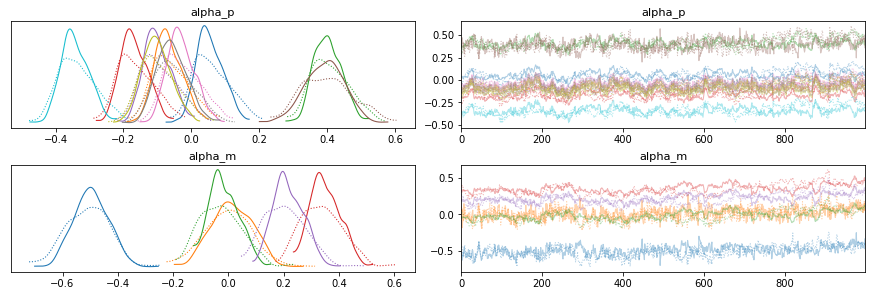

In [54]:
az.plot_trace(posterior, var_names=['alpha_p', 'alpha_m'])

Since we are performing a logistic regression, these coefficients can be tricky to interpret. When the bias $\alpha > 0$ this means that we need to add to the latent popularity to get the observation, which means that the pollster/method tends to be biased towards giving higher popularity scores.

Let us sort the pollsters by bias:

In [42]:
avg_bias = np.mean(posterior['alpha_p'], axis=0)
pollsters = pd.Categorical(data['sondage']).categories
dict(zip(pollsters, avg_bias))

{'BVA': 0.054793042546533215,
 'Elabe': -0.06664933132944652,
 'Harris': 0.4030811646417512,
 'Ifop': -0.16864731356377538,
 'Ipsos': -0.1011043239255054,
 'Kantar': 0.39659321585144564,
 'Odoxa': -0.031247310848554123,
 'OpinionWay': -0.05669812946404643,
 'Viavoice': -0.10140051344452285,
 'YouGov': -0.34357923175481636}

Let us look at the different methods:

In [43]:
avg_bias = np.mean(posterior['alpha_m'], axis=0)
methods = pd.Categorical(data['method']).categories
dict(zip(methods, avg_bias))

{'face to face': -0.5389589849160734,
 'internet': -0.059325269817523923,
 'phone': 0.3062141071728118,
 'phone&internet': 0.17327179551171276}

**TODO:** Interpret and compare to data. It is complicated since we plotted $\bar{p} - p$ which is confusing.  

There is a strong discrepancy for Kantar between what we observe and what the model returns. We saw earlier that all face-to-face polls were from Kantar. The bias may thus be fully captured by the face-to-face interaction. It is almost a philosophical question here whether the bias is due to the method or the bias, and this region of the posterior is weakly identified by the data so the coefficients corresponding to Kantar and face-to-face should not be interpreted separately.

On the other hand, the posterior coefficients for the method bias agree with our observation of the data.

The model has decided, Kantar does nothing special, it's all due to face-to-face :D

We now plot the posterior values of $\mu$. Since the model is completely pooled, we only have 60 values which correspond to a term:

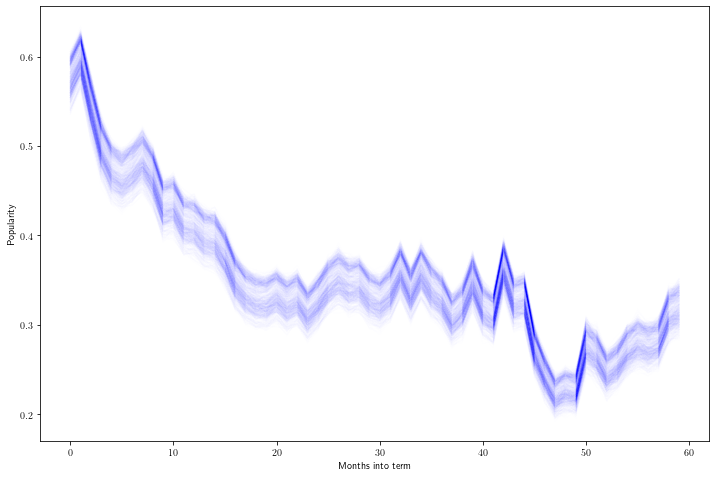

In [44]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

fig, ax = plt.subplots(figsize=(12,8))
for i in range(1000):
    ax.plot(range(60), inv_logit(posterior['mu'][i,:]), alpha=.005, color="blue")
ax.set_ylabel("Popularity")
ax.set_xlabel("Months into term");

**TODO:** Posterior predictive analysis - distribution of $p_{\mathrm{approve}}$ for each pollster and method. We can plot the approval rates for each poll for each president but we do not except anything to come from it because we mixed all the terms (although we may see a difference due to new pollsters appearing).  

**TODO:** Re-read the paper by Gellman et al. on predicting the US presidential election. We may be able to catch something new given our experience with this first model.

**TODO:** Try out-of-sample popularity prediction.

**TODO:** Test the sensitivity to $\sigma$ in the random walk.

**TODO:** Learn $\sigma$ from data?

The natural next step is partial pooling for the values of $\mu$